# Reinforced Concrete Frame Analysis

This notebook explains the analysis of the reinforced concrete frame shown below using OpenSeesPy. The frame will be analyzed using gravity load analysis and pushover analysis. The example is sourced from the OpenSees wiki [here](https://opensees.ist.berkeley.edu/wiki/index.php?title=Reinforced_Concrete_Frame_Example). The code used in the notebook is a modified version of the scripts provided in the OpenSeesPy documentation [here](https://openseespydoc.readthedocs.io/en/latest/src/RCFrameGravity.html). This notebook will also introduce the use of the 'opsvis' module. The documentation for this module can be found [here](https://opsvis.readthedocs.io/en/latest/). The reader should use this module when they tackle problems using OpenSeesPy in the future. The module is very simple to use and is excellent for problem visualization and understanding what is happening in each step. 


## Diagram

![Reinforced concrete frame diagram.PNG](<attachment:Reinforced concrete frame diagram.PNG>)
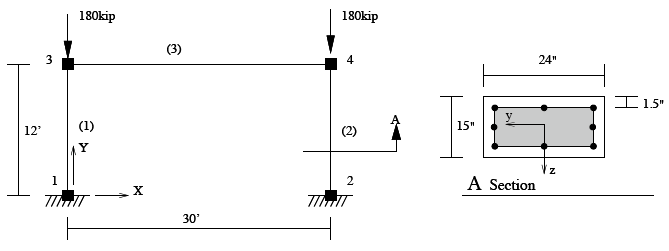

Below the required modules are imported and important variables are defined.

In [70]:
import openseespy.opensees as ops
import numpy as np
import opsvis as opsv
import matplotlib.pyplot as plt
import os

#Units
m = 1
mm = 0.001*m
N = 1
kN = 1000*N
Pa = 1

inches = 0.0254*m
ft = 12*inches
kip = 4.45*10**3*N
ksi = 6.89*10**6*Pa

# Portal frame dimensions
width = 30*ft
height = 12*ft

# Column dimensions
colWidth = 15*inches
colDepth = 24*inches

# Steel reinforcement
cover = 1.5*inches
As = (0.60*inches)**2  # area of no. 7 bars
fy = 60.0;  # Yield stress
E = 30000.0;  # Young's modulus

# Column centrelines
y1 = colDepth / 2.0
z1 = colWidth / 2.0

# Beam properties
A_beam = 360.0
E_beam = 4030.0
Iz_beam = 8640.0

# Set deflection tolerance
tol = 1e-6

## Model Definition

This code block executes the model definition, creates notes, and sets boundary conditions. Refer to the Basic Truss Example notebook for an explanation of these commands. Then the 'plot_model' command from the opsvis module is used to plot the model nodes.

Text(0.5, 1.0, 'Plot of model nodes')

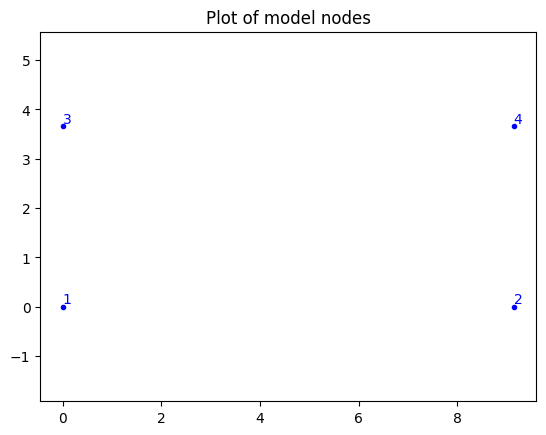

In [71]:
ops.wipe()

#Create file path for data output
if not os.path.exists('Data'):
    os.mkdir('Data')

# Model Definition
# ----------------

# Create ModelBuilder (with two-dimensions and 3 DOF/node)
ops.model('basic', '-ndm', 2, '-ndf', 3)

# Create nodes
#         tag, X, Y
ops.node(1, 0.0, 0.0)
ops.node(2, width, 0.0)
ops.node(3, 0.0, height)
ops.node(4, width, height)

# Fix supports at base of columns
#   tag, DX, DY, RZ
ops.fix(1, 1, 1, 1)
ops.fix(2, 1, 1, 1)

#Plot the model
opsv.plot_model()
plt.title('Plot of model nodes')

Shown below is the material definition. Refer to the Basic Truss Example notebook for an explanation of uniaxialMaterial command. The cover concrete, outside of the steel reinforcement, is expected to perform differently than the core concrete, inside of steel reinforcement. Therefore two seperate materials are defined for concrete within these reigon as seen below.

In [72]:
# Define materials for nonlinear columns
# ------------------------------------------

# CONCRETE                        tag  f'c    ec0    f'cu   ecu
# Core concrete (confined)
ops.uniaxialMaterial('Concrete01', 1, -6.0, -0.004, -5.0, -0.014)

# Cover concrete (unconfined)
ops.uniaxialMaterial('Concrete01', 2, -5.0, -0.002, 0.0, -0.006)

# STEEL                        tag  fy E0    b
ops.uniaxialMaterial('Steel01', 3, fy, E, 0.01)


Shown below is the definition of the column cross-section. The cross-section was both defined and plotted using the opsvis module. To do so, a list of lists (fib_sec_1) was created which defines a list of OpenSeesPy commands. Each list, within fib_sect_1, defines the command 'type' and then all of the command inputs. Now, fib_sect_1 is used to plot the section using the opsvis 'plot_fibre_section' command. This to allow the reader to visualise the section. Then fib_sect_1 is changed to OpenSeesPy commands using the opsvis 'fib_sec_list_to_cmds' command. This executes the commands as they would be called using OpenSeesPy. 

The standard way of defining the section using OpenSeesPy is shown in the commented-out code below. The 'section' command with command type 'Fiber' allows the creation of a Fiber Section object. A fiber section object is a cross-section that changes across defined boundaries. In the case of this example, the cross-section differs in the 'confined concrete' region in comparison to the 'cover concrete' region. These regions are defined by the placement of reinforcement within the cross-section. The regions are defined in OpenSeesPy using the 'patch' command. By using the patch command type 'rect' several rectangular-shaped fibers are created within a region of the Fibre Section that you define. In the case of this example, one rectangle region is used to define the core concrete (plotted in red), and four rectangle regions are used to define the surrounding cover concrete (plotted in light grey). These reigons can be split up into numerous fibers as seen in the patch command documentation [here](https://openseespydoc.readthedocs.io/en/latest/src/patch.html). In the case of this example, the core concrete cover, top and bottom cover, and left and right cover are split into 10, 2 and 10 fibres respectively (see plot of fibre section). The reigons are split up across the length of the y-axis, because bending is occuring about the strong axis of the section.

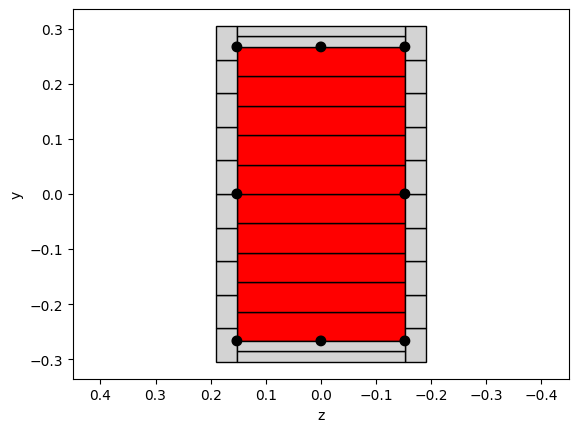

In [73]:
# Plot the fibre section
fib_sec_1 = [['section', 'Fiber', 1, '-GJ', 1.0e6],
             ['patch', 'rect', 1, 10, 1, cover - y1, cover - z1, y1 - cover, z1 - cover],  # core concrete
             ['patch', 'rect', 2, 10, 1, -y1, z1 - cover, y1, z1],  # left cover
             ['patch', 'rect', 2, 10, 1, -y1, -z1, y1, cover - z1],  # right cover
             ['patch', 'rect', 2, 2, 1, -y1, cover - z1, cover - y1, z1 - cover],  # top cover
             ['patch', 'rect', 2, 2, 1, y1 - cover, cover - z1, y1, z1 - cover],  # bottom cover 
             ['layer','straight', 3, 3, As, y1 - cover, z1 - cover, y1 - cover, cover - z1], # Left layer of steel reinforcement
             ['layer','straight', 3, 2, As, 0.0, z1 - cover, 0.0, cover - z1], # Middle layer
             ['layer','straight', 3, 3, As, cover - y1, z1 - cover, cover - y1, cover - z1] #right layer
             ]            

matcolor = ['r', 'lightgrey']
opsv.plot_fiber_section(fib_sec_1, matcolor=matcolor)
plt.axis('equal')
plt.show()

opsv.fib_sec_list_to_cmds(fib_sec_1)

# Define cross-section for nonlinear columns
# ------------------------------------------

# ops.section('Fiber', 1)

# # Create the concrete core fiber
# ops.patch('rect', 1, 10, 1, cover - y1, cover - z1, y1 - cover, z1 - cover)

# # Create the concrete cover fibers (top, bottom, left, right)
# ops.patch('rect', 2, 10, 1, -y1, z1 - cover, y1, z1)
# ops.patch('rect', 2, 10, 1, -y1, -z1, y1, cover - z1)
# ops.patch('rect', 2, 2, 1, -y1, cover - z1, cover - y1, z1 - cover)
# ops.patch('rect', 2, 2, 1, y1 - cover, cover - z1, y1, z1 - cover)

# # Create the reinforcing fibers (left, middle, right)
# ops.layer('straight', 3, 3, As, y1 - cover, z1 - cover, y1 - cover, cover - z1)
# ops.layer('straight', 3, 2, As, 0.0, z1 - cover, 0.0, cover - z1)
# ops.layer('straight', 3, 3, As, cover - y1, z1 - cover, cover - y1, cover - z1)

Shown below is the definition and plotting of elements. There are a few new commands here that need to be explained in detail, so let's break it down.

#### geoTransf command

The geomTransf command is used to define a geometric transformation for the column elements. It is important because it converts the local coordinate system of the column elements to the global coordinate system. There are 3 different types of geometric transformations that can be used:

- Linear Transformation: This is the most simple transformation and is suitable for first-order linear elastic analysis where the geometry of the model doesn't significantly change during loading. i.e. Small deflections are expected.

- P-Delta Transformation: This transformation should be used for second-order elastic analysis where additional moments are expected from lateral deflection of the structure under load i.e. P-Delta effects. 

- Corotational Transformation: This transformation is used for second-order non-linear analysis and should be used where larger deformation is expected to occur. The transformation accounts for large rotations of elements and geometric nonlinearity. 

#### beamIntegration command

The 'beamIntegration' command selects the numerical integration algorithm that will be used for a beam element and allows the user to select the distribution of integration points along the element. There are 15 different beamIntergration types available in OpenSeesPy, detailed in the documentation [here](https://openseespydoc.readthedocs.io/en/latest/src/beamIntegration.html). These integration types can be broken down into two categories:

- Integration methods for distributed plasticity: These integration types allow for plastic deformation to occur along the entire length of the element. These approaches are more detailed and should be used when distributed loads or complex loading conditions are imposed on a model.

- Plastic Hinge integration methods: These integration types make the assumption that plastic deformation is concentrated at specified locations. These approaches are more simple and therefore less accurate but are computationally more efficient. When using this type of integration method the user should select the command type based on the locations that plastic hinges are expected to form



In this example, the goemTransf command with the type PDelta is used. This is because some lateral deflection and therefore PDelta effects could be possible as a result of column buckling or deflection. The beamIntegration command is then used to select the 'Lobatto' integration type, which is a distributed plasticity integration type. This is chosen for improved accuracy and because the model is not expected to form plastic hinges.


<Axes: >

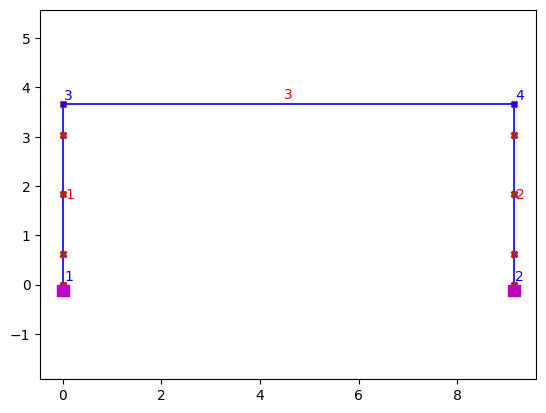

In [74]:
# Define column elements
# ----------------------
#                type   tag
ops.geomTransf('PDelta', 1)

# Number of integration points along length of element
np = 5

# Lobatto integration
#              type  integrationTag  sectionTag  np
ops.beamIntegration('Lobatto', 1, 1, np)

# Create the coulumns using Beam-column elements
#            type tag elenodes() transfTag integrationTag
eleType = 'forceBeamColumn'
ops.element(eleType, 1, 1, 3, 1, 1)
ops.element(eleType, 2, 2, 4, 1, 1)


# Define beam element
# -----------------------------
#                type   tag
ops.geomTransf('Linear', 2)

# Create the beam element
#                              tag  elenodes()                    transfTag
ops.element('elasticBeamColumn', 3, 3, 4, A_beam, E_beam, Iz_beam, 2)

#Plot the model
opsv.plot_model()

Showm belpw os Load definition using timeSeries, pattern, and load commands. Refer to basic truss example notebook for explaination of these commands.

In [75]:
# Define gravity loads
# --------------------

#  a parameter for the axial load
P = 180.0;  # 10% of axial capacity of columns

# Create a Plain load pattern with a Linear TimeSeries
ops.timeSeries('Linear', 1)
ops.pattern('Plain', 1, 1)

# Create nodal loads at nodes 3 & 4
#        nd  FX  FY  MZ
ops.load(3, 0.0, -P, 0.0)
ops.load(4, 0.0, -P, 0.0)

# ------------------------------
# End of model generation
# ------------------------------

## Analysis

The commands used in the analysis script below are explained in the Basic Truss Example, with the exclusion of the 'test command'.

The test command sets up a convergence test that checks if the norm of the displacement increments is below a specified tolerance within a given number of iterations. This ensures that the solution has converged to an acceptable level of accuracy during the analysis.

In [76]:
# Create the system of equations
ops.system('BandGeneral')

# Create the constraint handler, the transformation method
ops.constraints('Plain')

# Create the DOF numberer, the reverse Cuthill-McKee algorithm
ops.numberer('RCM')

# Create the convergence test, type is norm of the residual
# tolerance of 1e-12 and a max number of iterations of 10
ops.test('NormDispIncr', 1.0e-12, 10, 3)

# Create the solution algorithm, a Newton-Raphson algorithm
ops.algorithm('Newton')

# Create the integration scheme, load control using steps of 0.1
ops.integrator('LoadControl', 0.1)

# Create the analysis object
ops.analysis('Static')

# perform the gravity load analysis, requires 10 steps to reach the load level
ops.analyze(10)

0

The deformed shape of the truss after gravity analysis is shown below using the opsvis module.

Text(0.5, 1.0, 'Deformed shape')

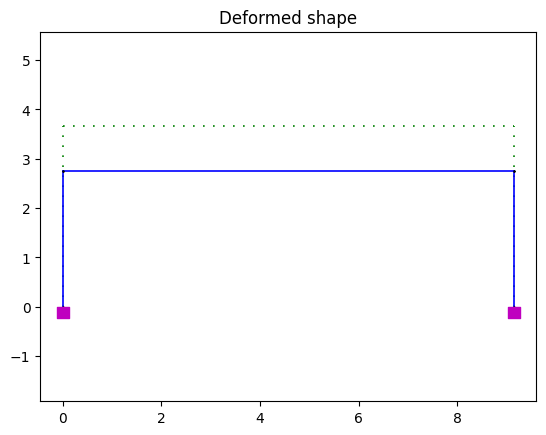

In [77]:
opsv.plot_defo()
plt.title('Deformed shape')

## Pushover Analysis

To start the pushover analysis, a new loading condition is defined using the pattern and node commands that are explained in the 'Basic Truss Example'.

In [78]:
# Set lateral load pattern with a Linear TimeSeries
ops.pattern('Plain', 2, 1)

# Create nodal loads at nodes 3 & 4
#      node FX  FY
ops.load(3, 10, 0.0, 0.0)
ops.load(4, 10, 0.0, 0.0)

The next block of code makes some modifications to the analysis of the model. To perform pushover analysis a 'displacement controlled' analysis is implemented using the intergrator command. This method determines the time step that will result in a specified displacement of a node in a specified direction i.e. how long it will take a specified displacement to occur. The command allows the user to specify and node of interest and its DoFs, the first displacement increment, the number of iterations they wish to use, and a range of acceptible step sizes. The test command is then called again to update the tolerance of the convergence test and the number of iterations.

In [79]:
# Displacement increment
dU = 0.1  

# Change the integration scheme to be displacement control
#                 integratorType   node dof init Jd min max
ops.integrator('DisplacementControl', 3, 1, dU, 1, dU, dU)

ops.test('NormDispIncr', 1.0e-8, 20)

ops.analyze(1)

0

Below, the deformed shape is plotted and displacements of nodes 3 and 4 are included in the title.

Text(0.5, 1.0, 'Deformed shape\nNode 3 Displacement: x = 0.1000 m, y = -0.7763 m\nNode 4 Displacement: x = 0.1000 m, y = -0.7801 m')

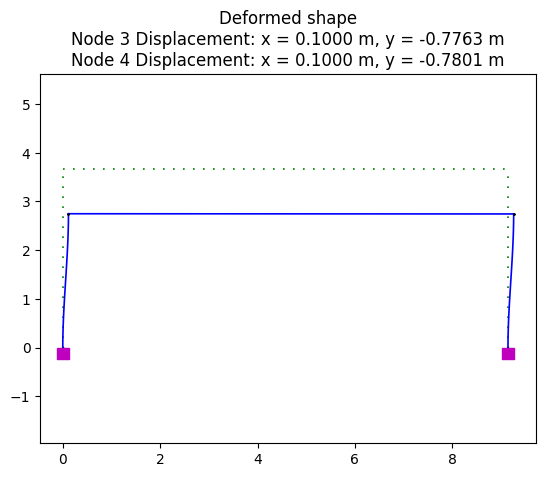

In [80]:
n3x = ops.nodeDisp(3, 1)
n3y = ops.nodeDisp(3, 2)

n4x = ops.nodeDisp(4, 1)
n4y = ops.nodeDisp(4, 2)

opsv.plot_defo()
plt.title(f'Deformed shape\nNode 3 Displacement: x = {n3x:.4f} m, y = {n3y:.4f} m\nNode 4 Displacement: x = {n4x:.4f} m, y = {n4y:.4f} m')